In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
train_df = pd.read_csv('/content/neg+pos.csv')

In [ ]:
train_df.shape

(25000, 4)

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load data
df = pd.read_csv('/content/neg+pos.csv')  # Replace with your CSV path

# Create binary classes: 0 (≤4), 1 (≥7)
df['class'] = df['rating'].apply(lambda x: 0 if x <= 4 else 1)

# First split: train (80%) vs temp (20%)
train_df, temp_df = train_test_split(
    df,
    test_size=0.2,  # 20% for test+validation
    stratify=df['class'],
    random_state=42
)

# Second split: validation (10%) vs test (10%) from temp (total 20%)
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,  # Split temp into equal halves (10% each)
    stratify=temp_df['class'],
    random_state=42
)

# Remove temporary class column if needed
df = df.drop(columns=['class'])

# Check class distribution in splits
print("Train set distribution:")
print(train_df['class'].value_counts(normalize=True))
print("\nValidation set distribution:")
print(val_df['class'].value_counts(normalize=True))
print("\nTest set distribution:")
print(test_df['class'].value_counts(normalize=True))

# Optional: Save splits to CSV
train_df.to_csv('train.csv', index=False)
val_df.to_csv('validation.csv', index=False)
test_df.to_csv('test.csv', index=False)

Train set distribution:
class
1    0.5
0    0.5
Name: proportion, dtype: float64

Validation set distribution:
class
1    0.5
0    0.5
Name: proportion, dtype: float64

Test set distribution:
class
1    0.5
0    0.5
Name: proportion, dtype: float64


In [ ]:
# label counts
def get_label_counts(df, dataset_name):
    label_counts = df['label'].value_counts()
    count_0 = label_counts.get(0, 0)  # label 0 as Negative
    count_1 = label_counts.get(1, 0)  # label 1 as Positive
    total_count = len(df)

    print(f"{dataset_name} Dataset:")
    print(f"Count of 0: {count_0}")
    print(f"Count of 1: {count_1}")
    print(f"Total Count: {total_count}\n")

# Getting label counts for all datasets
get_label_counts(train_df, "Training")
get_label_counts(val_df, "Validation")
get_label_counts(test_df, "Testing")

Training Dataset:
Count of 0: 10000
Count of 1: 10000
Total Count: 20000

Validation Dataset:
Count of 0: 1250
Count of 1: 1250
Total Count: 2500

Testing Dataset:
Count of 0: 1250
Count of 1: 1250
Total Count: 2500



In [ ]:
train_df.tail()

,sl_no,text,rating,label,class
10080,7823,"An overlong, but compelling retelling of the f...",7,1,1
7973,5927,Stephen King movies are a funny thing with me....,9,1,1
22968,8172,A cannibalistic backwoods killer is on the pro...,1,0,0
17663,3398,It seems that the intention of the film was to...,3,0,0
10894,8556,This movie is plain fun.I has nothing to do wi...,7,1,1


In [ ]:
column = 'label'

In [ ]:
train_df[column].unique(), val_df[column].unique(), test_df[column].unique()

(array([1, 0]), array([1, 0]), array([1, 0]))

In [ ]:
train_df.isnull().sum(), val_df.isnull().sum(), test_df.isnull().sum()

(sl_no     0
 text      0
 rating    0
 label     0
 class     0
 dtype: int64,
 sl_no     0
 text      0
 rating    0
 label     0
 class     0
 dtype: int64,
 sl_no     0
 text      0
 rating    0
 label     0
 class     0
 dtype: int64)

Text Preprocessing

In [ ]:
import nltk
import re
from tqdm import tqdm
import string
from collections import Counter
from wordcloud import WordCloud
from nltk.corpus import stopwords
import torch
import torch.nn as nn
import torch.optim as optim

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
STOPWORDS=set(stopwords.words('english'))

In [ ]:
def remove_url_and_email(string):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')

    email_pattern = re.compile(r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Za-z]{2,}\b')

    string = url_pattern.sub(r'', string)
    string = email_pattern.sub(r'', string)

    return string

def remove_html(text):
    html_pattern = re.compile('<.*?>')
    return html_pattern.sub(r'',text)


def text_preprocess(df):
  df['cleaned_text'] = df['text'].apply(lambda x: " ".join([word.lower() for word in x.split()])) # Lowercase removed
  df['cleaned_text'] = df['cleaned_text'].apply(lambda x: remove_url_and_email(x)) #  URLs removed
  df['cleaned_text'] = df['cleaned_text'].apply(lambda x: remove_html(x)) #  HTML tags removed
  df['cleaned_text'] = df['cleaned_text'].apply(lambda x: " ".join([word for word in x.split() if word not in STOPWORDS])) #  stopwords removed
  df['cleaned_text'] = df['cleaned_text'].apply(lambda x: re.sub(r'[^\w\s]', ' ', x)) #  punctuation removed
  df['cleaned_text'] = df['cleaned_text'].apply(lambda x: re.sub(r'\d+', '', x)) #  digits removed
  df['cleaned_text'] = df['cleaned_text'].apply(lambda x: re.sub(r'\s+', ' ', x)) #  extra whitespace removed
  df['cleaned_text'] = df['cleaned_text'].apply(lambda x: " ".join([word for word in x.split() if len(word) > 2])) #  short words removed
  df['cleaned_text'] = df['cleaned_text'].apply(lambda x: [word for word in x.split()]) # tokenize

  return df

In [ ]:
new_train_df = text_preprocess(train_df)
new_val_df = text_preprocess(val_df)
new_test_df = text_preprocess(test_df)

In [ ]:
new_train_df.tail()

,sl_no,text,rating,label,class,text_cleaned
10080,7823,"An overlong, but compelling retelling of the f...",7,1,1,"[overlong, compelling, retelling, friendship, ..."
7973,5927,Stephen King movies are a funny thing with me....,9,1,1,"[stephen, king, movies, funny, thing, either, ..."
22968,8172,A cannibalistic backwoods killer is on the pro...,1,0,0,"[cannibalistic, backwoods, killer, prowl, two,..."
17663,3398,It seems that the intention of the film was to...,3,0,0,"[seems, intention, film, show, aggressive, maf..."
10894,8556,This movie is plain fun.I has nothing to do wi...,7,1,1,"[movie, plain, fun, nothing, original, america..."


TEXT VISULAIZATION

In [ ]:
new_train_df['length'] = new_train_df['cleaned_text'].apply(lambda x: len(x))
new_val_df['length'] = new_val_df['cleaned_text'].apply(lambda x: len(x))
new_test_df['length'] = new_test_df['cleaned_text'].apply(lambda x: len(x))

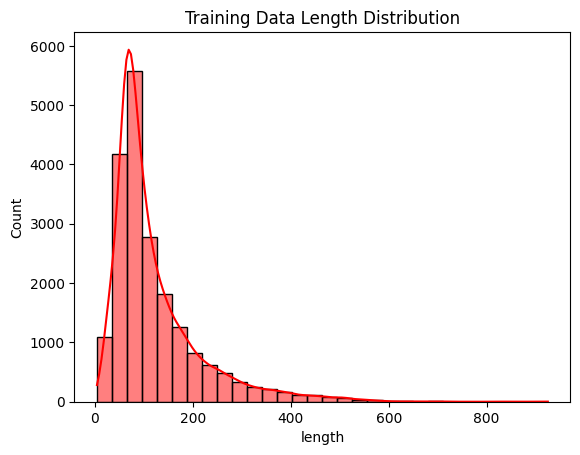

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a figure with 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot Training Data Length Distribution
sns.histplot(new_train_df['length'], kde=True, color='red', bins=30, ax=axes[0])
axes[0].set_title('Training Data Length Distribution')

# Plot Validation Data Length Distribution
sns.histplot(new_val_df['length'], kde=True, color='red', bins=30, ax=axes[1])
axes[1].set_title('Validation Data Length Distribution')

# Plot Testing Data Length Distribution
sns.histplot(new_test_df['length'], kde=True, color='red', bins=30, ax=axes[2])
axes[2].set_title('Testing Data Length Distribution')

# Show the plots
plt.tight_layout()
plt.show()

In [ ]:
new_train_df

,sl_no,text,rating,label,class,text_cleaned,length
7522,5520,Many reviews I've read reveals that most peopl...,9,1,1,"[many, reviews, read, reveals, people, tend, l...",246
17493,3244,The effect achieved in this story about a psyc...,3,0,0,"[effect, achieved, story, psychiatrist, become...",96
12260,9786,I really enjoyed the performances of the main ...,8,1,1,"[really, enjoyed, performances, main, cast, em...",57
1275,11148,'Midnight Cowboy' was rated X with the origina...,9,1,1,"[midnight, cowboy, rated, original, release, b...",115
8004,5955,"As the maker of ""This Darkness,"" I admit we ne...",10,1,1,"[maker, this, darkness, admit, neglected, impo...",64
...,...,...,...,...,...,...,...
10080,7823,"An overlong, but compelling retelling of the f...",7,1,1,"[overlong, compelling, retelling, friendship, ...",56
7973,5927,Stephen King movies are a funny thing with me....,9,1,1,"[stephen, king, movies, funny, thing, either, ...",137
22968,8172,A cannibalistic backwoods killer is on the pro...,1,0,0,"[cannibalistic, backwoods, killer, prowl, two,...",57
17663,3398,It seems that the intention of the film was to...,3,0,0,"[seems, intention, film, show, aggressive, maf...",67


VOCAB

In [ ]:
vocab = Counter()
for text in new_train_df['cleaned_text']:
    vocab.update(text)

for text in new_val_df['cleaned_text']:
    vocab.update(text)

for text in new_test_df['cleaned_text']:
    vocab.update(text)

In [ ]:
vocab_sorted = vocab.most_common()

In [ ]:
vocab_sorted = ['<pad>'] + [word for word, _ in vocab_sorted]

In [ ]:
vocab_sorted[:15]

['<pad>',
 'movie',
 'film',
 'one',
 'like',
 'good',
 'the',
 'time',
 'even',
 'would',
 'story',
 'really',
 'see',
 'well',
 'much']

In [ ]:
vocab_size = len(vocab_sorted)
print(vocab_size)

74025


In [ ]:
word_to_index = {word: index for index, word in enumerate(vocab_sorted)} # enumerated
index_to_word = {index: word for index, word in enumerate(vocab_sorted)}

PADDING AND TRUNCATION

In [ ]:
def padding_truncated(text_list,max_sequence):
    if len(text_list) > max_sequence:
        return text_list[:max_sequence]
    else:
        return text_list + ['<pad>'] * (max_sequence - len(text_list))

In [ ]:
new_train_df['cleaned_text'] = new_train_df['cleaned_text'].apply(lambda x: padding_truncated(x,400))
new_val_df['cleaned_text'] = new_val_df['cleaned_text'].apply(lambda x: padding_truncated(x,400))
new_test_df['cleaned_text'] = new_test_df['cleaned_text'].apply(lambda x: padding_truncated(x,400))

In [ ]:
new_train_df['text_seq'] = new_train_df['cleaned_text'].apply(lambda x: [word_to_index[word] for word in x])
new_val_df['text_seq'] = new_val_df['cleaned_text'].apply(lambda x: [word_to_index[word] for word in x])
new_test_df['text_seq'] = new_test_df['cleaned_text'].apply(lambda x: [word_to_index[word] for word in x])

In [ ]:
new_train_df.tail()

,sl_no,text,rating,label,class,text_cleaned,text_seq
7522,5520,Many reviews I've read reveals that most peopl...,9,1,1,"[many, reviews, read, reveals, people, tend, l...","[34, 730, 226, 2536, 17, 2209, 4, 76, 3, 47, 7..."
17493,3244,The effect achieved in this story about a psyc...,3,0,0,"[effect, achieved, story, psychiatrist, become...","[823, 3158, 10, 3500, 348, 457, 2577, 2560, 72..."
12260,9786,I really enjoyed the performances of the main ...,8,1,1,"[really, enjoyed, performances, main, cast, em...","[11, 394, 248, 185, 81, 2325, 8977, 7799, 116,..."
1275,11148,'Midnight Cowboy' was rated X with the origina...,9,1,1,"[midnight, cowboy, rated, original, release, b...","[2600, 2236, 1015, 100, 645, 56, 54, 284, 30, ..."
8004,5955,"As the maker of ""This Darkness,"" I admit we ne...",10,1,1,"[maker, this, darkness, admit, neglected, impo...","[2738, 44, 2406, 844, 6757, 553, 45979, 49, 76..."


In [ ]:
train_data = new_train_df[['text_seq', 'label']]
val_data = new_val_df[['text_seq', 'label']]
test_data = new_test_df[['text_seq', 'label']]

CREATE DATASET TENSOR

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

In [ ]:
class Sentiment_Data_set(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text_seq = self.data.iloc[idx]['text_seq']
        label = self.data.iloc[idx]['label']
        return torch.tensor(text_seq), torch.tensor(label)

In [ ]:
train_dataset = Sentiment_Data_set(train_data)
val_dataset = Sentiment_Data_set(val_data)
test_dataset = Sentiment_Data_set(test_data)

In [ ]:
train_dataset[0]

(tensor([   34,   730,   226,  2536,    17,  2209,     4,    76,     3,    47,
            76,    31,   127,   500,  1833,    76,     3,   149,    88,   121,
            14,   161,    74,   168,   646,   674,  2198,  7330,  1475,   168,
          1965,     2,  1911,   168,  1851,  2243,    56,  2443,  2576,  6568,
          2471,    76,  8031,  8343,   523,  3904,    76,    31,  2198,  3300,
          8976,   261,  2400, 19647,  1482,  2085,  2283,  1312,   701, 45975,
          2842,  7672, 16931,   537,  1746, 45976,   199,  1090,  2472,  2198,
         37044, 45977,  3685,    17,  1641, 15494,   124,   344,   128,  3937,
          5244, 28445,   347,   356,  2198,    35,    57,   179,    17,  2638,
            76,     3,    76,    31,     6,   530, 14909,  1482,    18, 22123,
           117,  2198,    76,     3,  2198,    76,    31,   758,    92,   227,
            31,  1295,   182,   392,  2283,  6845,  6662, 12218,  6662, 12218,
          2198,   466,   438,  5076,   466,  7546, 1

In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


BUILD MODEL

In [ ]:
class lstm_model(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.bidirectional = bidirectional
        self.lstm = nn.LSTM(
            embedding_dim,
            hidden_dim,
            num_layers=n_layers,
            bidirectional=bidirectional,
            batch_first=True,
        )
        self.dropout = nn.Dropout(dropout)  # Dropout layer
        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()

    def init_hidden(self, batch_size):
        factor = 2 if self.bidirectional else 1
        h0 = torch.zeros(self.n_layers * factor, batch_size, self.hidden_dim).to(device)
        c0 = torch.zeros(self.n_layers * factor, batch_size, self.hidden_dim).to(device)
        hidden = (h0, c0)
        return hidden

    def forward(self, x, hidden):
        batch_size = x.size(0)
        embedded = self.embedding(x)  # Embedding layer
        lstm_out, hidden = self.lstm(embedded, hidden)  # LSTM layer

        lstm_out = self.dropout(lstm_out)

        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim * 2 if self.bidirectional else self.hidden_dim)

        out = self.fc(lstm_out) # flatten

        sig_out = self.sigmoid(out) # sigmoid activation

        sig_out = sig_out.view(batch_size, -1)
        sig_out = sig_out[:, -1]

        return sig_out, hidden

In [ ]:
def acc(pred, label):
    pred = torch.round(pred.squeeze())
    return torch.sum(pred == label.squeeze()).item()

In [ ]:
def binary_accuracy(preds, y):
    #round predictions to the closest integer
    rounded_preds = torch.round(preds)

    correct = (rounded_preds == y).float()
    acc = correct.sum() / len(correct)
    return acc

UNIDIRECTIONAL LSTM

In [ ]:
embedding_dim = 128
hidden_dim = 256
output_dim = 1
n_layers = 2
bidirectional = False
dropout = 0.5

model = lstm_model(vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout)
model = model.to(device)

print(model)

lstm_model(
  (embedding): Embedding(74025, 128)
  (lstm): LSTM(128, 256, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [ ]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()

In [ ]:
EPOCHS = 15
train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []

In [ ]:
for epoch in tqdm(range(EPOCHS)):
    model.train()
    train_loss = 0.0
    train_acc = 0.0
    for text_seq, label in train_dataloader:
        text_seq, label = text_seq.to(device), label.to(device)
        hidden = model.init_hidden(text_seq.size(0))
        optimizer.zero_grad()
        output, _ = model(text_seq, hidden)
        loss = criterion(output, label.float())
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_acc += binary_accuracy(output, label)

    model.eval()
    val_loss = 0.0
    val_acc = 0.0
    with torch.no_grad():
        for text_seq, label in val_dataloader:
            text_seq, label = text_seq.to(device), label.to(device)
            hidden = model.init_hidden(text_seq.size(0))
            output, _ = model(text_seq, hidden)
            loss = criterion(output, label.float())
            val_loss += loss.item()
            val_acc += binary_accuracy(output, label)

    train_loss /= len(train_dataloader)
    train_acc /= len(train_dataloader)
    val_loss /= len(val_dataloader)
    val_acc /= len(val_dataloader)
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)
    print(f'Epoch: {epoch+1}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc*100:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc*100:.4f}')

  7%|▋         | 1/15 [00:28<06:37, 28.40s/it]

Epoch: 1, Train Loss: 0.6944, Train Acc: 49.3450, Val Loss: 0.6927, Val Acc: 50.2373


 13%|█▎        | 2/15 [00:55<06:01, 27.78s/it]

Epoch: 2, Train Loss: 0.6932, Train Acc: 50.1150, Val Loss: 0.6932, Val Acc: 49.9209


 20%|██        | 3/15 [01:24<05:37, 28.10s/it]

Epoch: 3, Train Loss: 0.6935, Train Acc: 50.2500, Val Loss: 0.6933, Val Acc: 50.3560


 27%|██▋       | 4/15 [01:53<05:12, 28.44s/it]

Epoch: 4, Train Loss: 0.6917, Train Acc: 50.3550, Val Loss: 0.6969, Val Acc: 50.2373


 33%|███▎      | 5/15 [02:22<04:46, 28.65s/it]

Epoch: 5, Train Loss: 0.6855, Train Acc: 50.6800, Val Loss: 0.6855, Val Acc: 57.3180


 40%|████      | 6/15 [02:51<04:18, 28.71s/it]

Epoch: 6, Train Loss: 0.6768, Train Acc: 53.4150, Val Loss: 0.7023, Val Acc: 50.2373


 47%|████▋     | 7/15 [03:20<03:50, 28.83s/it]

Epoch: 7, Train Loss: 0.6726, Train Acc: 53.1300, Val Loss: 0.7187, Val Acc: 54.1139


 53%|█████▎    | 8/15 [03:49<03:22, 28.98s/it]

Epoch: 8, Train Loss: 0.5813, Train Acc: 69.4800, Val Loss: 0.4546, Val Acc: 80.8149


 60%|██████    | 9/15 [04:18<02:54, 29.04s/it]

Epoch: 9, Train Loss: 0.3322, Train Acc: 87.0950, Val Loss: 0.4020, Val Acc: 84.2563


 67%|██████▋   | 10/15 [04:47<02:25, 29.13s/it]

Epoch: 10, Train Loss: 0.2007, Train Acc: 93.4250, Val Loss: 0.3917, Val Acc: 85.9573


 73%|███████▎  | 11/15 [05:16<01:56, 29.10s/it]

Epoch: 11, Train Loss: 0.1134, Train Acc: 96.8850, Val Loss: 0.4986, Val Acc: 84.7706


 80%|████████  | 12/15 [05:46<01:27, 29.11s/it]

Epoch: 12, Train Loss: 0.0679, Train Acc: 98.4650, Val Loss: 0.5958, Val Acc: 84.5728


 87%|████████▋ | 13/15 [06:15<00:58, 29.10s/it]

Epoch: 13, Train Loss: 0.0504, Train Acc: 98.9750, Val Loss: 0.5959, Val Acc: 84.8497


 93%|█████████▎| 14/15 [06:44<00:29, 29.07s/it]

Epoch: 14, Train Loss: 0.0456, Train Acc: 99.1250, Val Loss: 0.6742, Val Acc: 84.2168


100%|██████████| 15/15 [07:13<00:00, 28.89s/it]

Epoch: 15, Train Loss: 0.0411, Train Acc: 99.2000, Val Loss: 0.6055, Val Acc: 84.8101


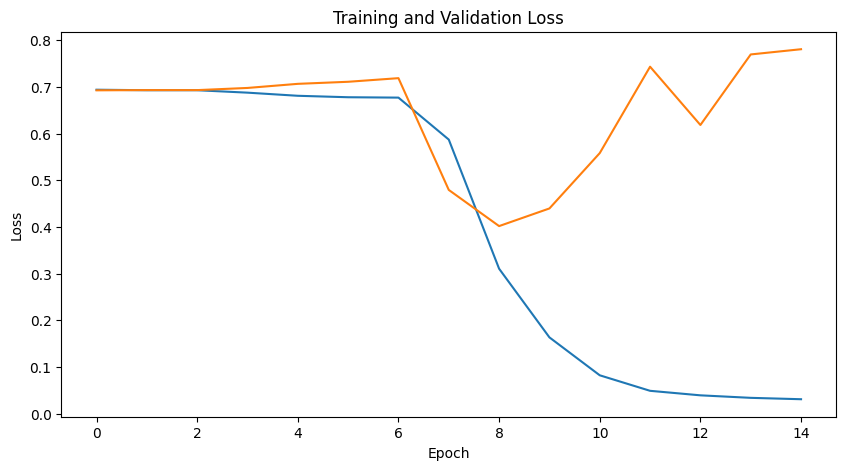

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(train_loss_list, label='Training_Loss')
plt.plot(val_loss_list, label='Validation_Loss')
plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.title('Training & Validation Loss')
plt.show()

In [ ]:
train_acc_list = [acc.cpu().numpy() for acc in train_acc_list] # GPU tensor
val_acc_list = [acc.cpu().numpy() for acc in val_acc_list]

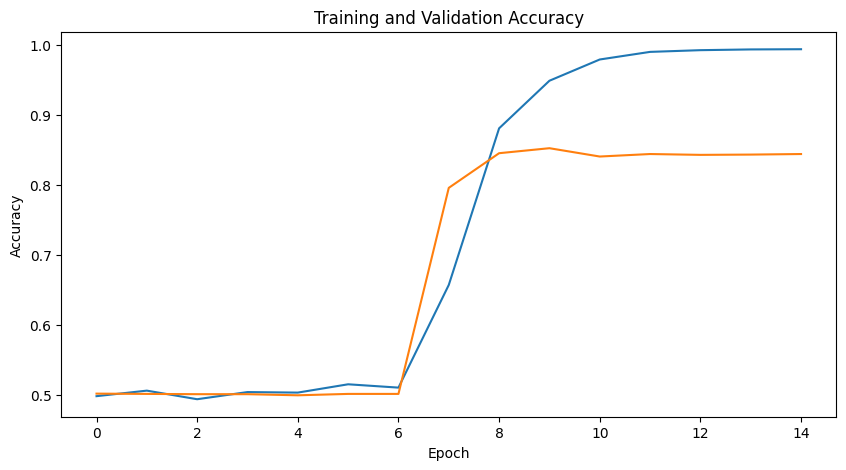

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(val_acc_list, label='Validation_Accuracy')
plt.plot(train_acc_list, label='Training_Accuracy')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.show()

In [ ]:
model.eval()
test_loss = 0.0
test_acc = 0.0
with torch.no_grad():
    for text_seq, label in test_dataloader:
        text_seq, label = text_seq.to(device), label.to(device)
        hidden = model.init_hidden(text_seq.size(0))
        output, _ = model(text_seq, hidden)
        loss = criterion(output, label.float())
        test_loss += loss.item()
        test_acc += binary_accuracy(output, label)

test_loss /= len(test_dataloader)
test_acc /= len(test_dataloader)
print(f'Test loss is {test_loss}')
print(f'Test accuracy is {test_acc}')

Test loss is 0.791201567748868
Test accuracy is 0.8425633311271667


In [ ]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for text_seq, label in test_dataloader:
        text_seq, label = text_seq.to(device), label.to(device)
        hidden = model.init_hidden(text_seq.size(0))

        output, _ = model(text_seq, hidden)

        preds = (output > 0.5).float()

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(label.cpu().numpy())

all_preds = np.array(all_preds).flatten()
all_labels = np.array(all_labels).flatten()

cm = confusion_matrix(all_labels, all_preds)

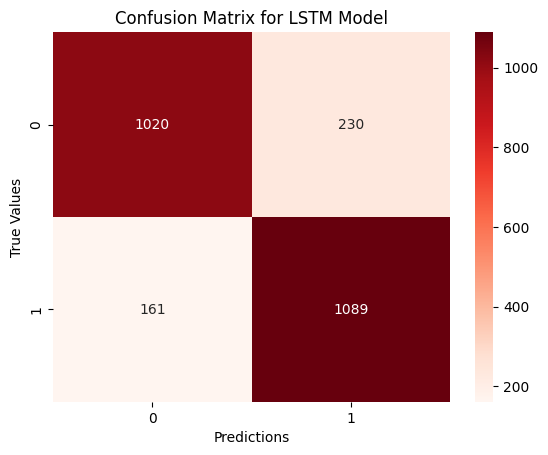

In [ ]:
sns.heatmap(cm,fmt='d',cmap='Reds',annot=True)
plt.xlabel('Predictions')
plt.ylabel('True Values')
plt.title('LSTM Confusion Matrix')
plt.show()

In [ ]:
UniLSTM_ClassificationReport = classification_report(all_labels,all_preds)
print('Classification Report of LSTM Model: \n', UniLSTM_ClassificationReport)

Classification Report for Unidirectional LSTM Model is : 
               precision    recall  f1-score   support

           0       0.86      0.82      0.84      1250
           1       0.83      0.87      0.85      1250

    accuracy                           0.84      2500
   macro avg       0.84      0.84      0.84      2500
weighted avg       0.84      0.84      0.84      2500

